<a href="https://colab.research.google.com/github/shanikairoshi/QFL-with-DUN/blob/main/Simple_VQC_and_deep_unfolded_vqc_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-machine-learning/vqc.ipynb

In [2]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 8.0 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512550 sha256=c9f2c3aa55ffc1a1e87ae1e815e797358f684679eb20f77cb2260faa8d622490
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d

Creating Qiskit Circuit

In [ ]:
from qiskit.circuit import QuantumCircuit, Parameter
theta = Parameter('θ')

qc = QuantumCircuit(2)
qc.rz(theta, 0)
qc.crz(theta, 0, 1)
qc.draw()

┌───────┐         
q_0: ┤ Rz(θ) ├────■────
     └───────┘┌───┴───┐
q_1: ─────────┤ Rz(θ) ├
              └───────┘

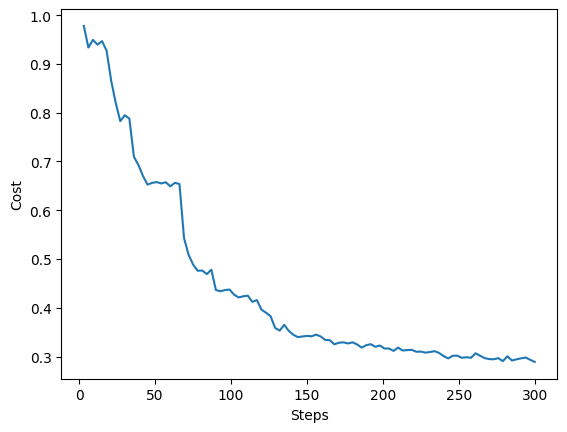

In [ ]:
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
# pylint: disable=unbalanced-tuple-unpacking
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)
# ZZfeatureMap for data encoding a
# Two Local for variational circuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

#We create a function that associates the data to the feature map and the variational parameters to the variational circuit.
#This is to ensure that the right parameters
#in the circuit are associated with the right quantities.

def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    # pylint: disable=invalid-name
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

from qiskit_aer import Aer
from qiskit import transpile # Import execute from qiskit


def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = Aer.get_backend('qasm_simulator')
    # Transpile and execute each circuit individually
    results = []
    for circuit in circuits:
        t_circuit = transpile(circuit, backend)
        result = backend.run(t_circuit).result() # Execute each transpiled circuit
        results.append(result)
    classification = [
        label_probability(result.get_counts()) for result in results] # Get counts from each result
    return classification


def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    # pylint: disable=invalid-name
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    # pylint: disable=invalid-name
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

# Set up the optimization
from qiskit_algorithms.optimizers import SPSA
#from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

Deep Unfolded Opt

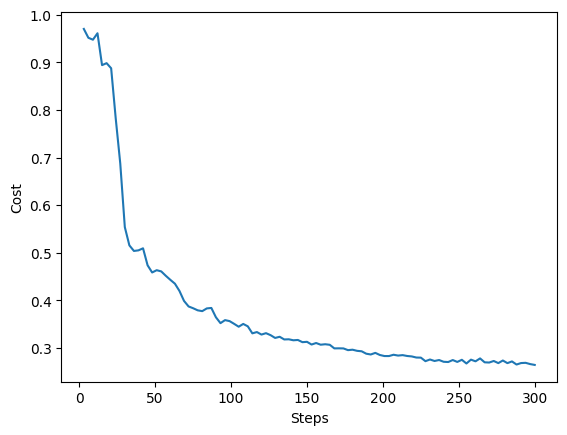

'\nThis hybrid approach leverages both data-driven learning and model-based optimization,\npotentially leading to more efficient optimization compared to traditional methods like SPSA.\n\n'

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
# pylint: disable=unbalanced-tuple-unpacking
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)
# ZZfeatureMap for data encoding a
# Two Local for variational circuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

#We create a function that associates the data to the feature map and the variational parameters to the variational circuit.
#This is to ensure that the right parameters
#in the circuit are associated with the right quantities.

def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    # pylint: disable=invalid-name
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

from qiskit_aer import Aer
from qiskit import transpile # Import execute from qiskit


def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = Aer.get_backend('qasm_simulator')
    # Transpile and execute each circuit individually
    results = []
    for circuit in circuits:
        t_circuit = transpile(circuit, backend)
        result = backend.run(t_circuit).result() # Execute each transpiled circuit
        results.append(result)
    classification = [
        label_probability(result.get_counts()) for result in results] # Get counts from each result
    return classification


def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    # pylint: disable=invalid-name
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    # pylint: disable=invalid-name
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

# Set up the optimization
from qiskit_algorithms.optimizers import SPSA
#from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
#optimizer = SPSA(maxiter=100, callback=log.update)

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

'''
Create a neural network that represents an iterative optimization algorithm.
Each layer of the network corresponds to a step in the optimization process.
This network will learn the update rules for the parameters during training
'''
class UnfoldedOptimizer(nn.Module):
    def __init__(self, input_dim):
        super(UnfoldedOptimizer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, input_dim)

    def forward(self, theta):
        x = torch.relu(self.fc1(theta))
        x = torch.relu(self.fc2(x))
        return theta - torch.sigmoid(self.fc3(x))  # Update rule

'''
Create an instance of this model and set it up with appropriate input dimensions
(which should be the number of variational parameters)
'''
unfolded_optimizer = UnfoldedOptimizer(input_dim=VAR_FORM.num_parameters)

'''
Instead of using the standard optimizer update, use the deep unfolded model to perform updates.
The objective_function remains the same, but now optimize it using a deep unfolding approach.
'''
'''
def generate_synthetic_data(optimizer, initial_point, steps=50):
    synthetic_data = []
    synthetic_labels = []
    parameter = initial_point
    for step in range(steps):
        cost = cost_function(TRAIN_DATA, TRAIN_LABELS, parameter)
        new_parameter = optimizer.minimize(objective_function, parameter).x  # Access 'x' using dot notation
        synthetic_data.append(parameter)
        synthetic_labels.append(new_parameter - parameter)
        parameter = new_parameter
    return np.array(synthetic_data), np.array(synthetic_labels)

synthetic_data, synthetic_labels = generate_synthetic_data(SPSA(maxiter=1), initial_point)

# Training the Unfolded Optimizer
def train_unfolded_optimizer(model, data, labels, epochs=10, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(torch.tensor(data, dtype=torch.float32))
        loss = loss_fn(outputs, torch.tensor(labels, dtype=torch.float32))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

train_unfolded_optimizer(unfolded_optimizer, synthetic_data, synthetic_labels)
'''
def deep_unfolding_update(evaluation, parameter, cost, _stepsize, _accept):
    # Convert parameter to tensor
    parameter_tensor = torch.tensor(parameter, dtype=torch.float32)

    # Update parameter using the unfolded optimizer
    with torch.no_grad():
        updated_parameter = unfolded_optimizer(parameter_tensor).numpy()

    # Log the updates
    log.update(evaluation, updated_parameter, cost, _stepsize, _accept)

    return updated_parameter

'''
Before integrating the deep unfolding model with the optimizer, need to train it.
This step involves training the neural network to learn the update rules from data,
 which could be generated from initial optimizations or synthetic data

'''
log = OptimizerLog()
# Example pseudo-code for training the model
# Assume we have a dataset of parameter updates and losses

'''
Finally, replace the standard callback with the deep unfolding update function in our optimizer.
'''
optimizer = SPSA(maxiter=100, callback=deep_unfolding_update)

# Run the optimization with the deep unfolding model
result = optimizer.minimize(objective_function, initial_point)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

'''
This hybrid approach leverages both data-driven learning and model-based optimization,
potentially leading to more efficient optimization compared to traditional methods like SPSA.

'''

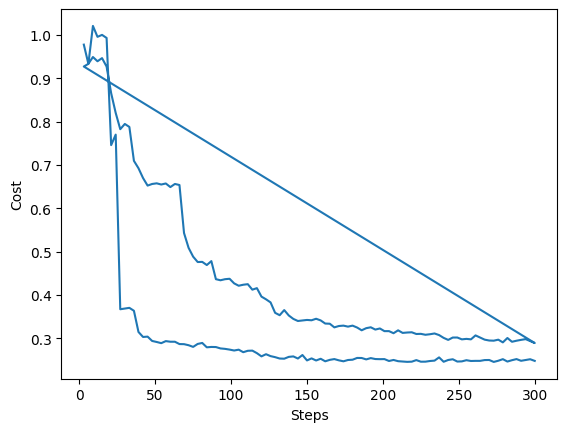

In [ ]:
# Number of final iterations to plot
n_final_iterations = 200

# Extract the final `n` cost values
final_costs = log.costs[-n_final_iterations:]  # Get the last `n_final_iterations` cost values

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, final_costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()


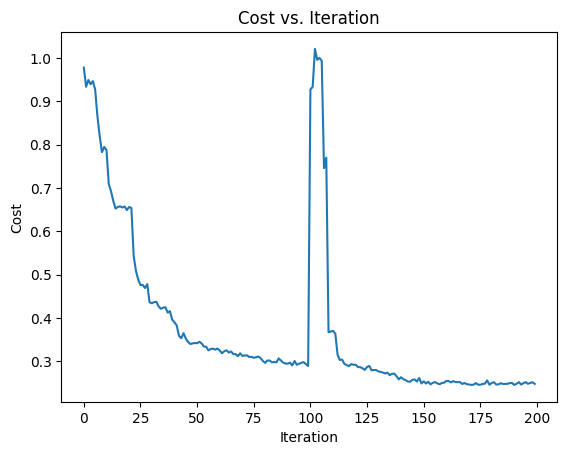

In [ ]:
# prompt: visualize last log.costs

import matplotlib.pyplot as plt

# Assuming log.costs contains the cost values
plt.plot(log.costs)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs. Iteration')
plt.show()


In [ ]:
print(len(log.costs))

200


Unrolling Opt

Layer 1, Cost: 0.5884677666727701
Layer 2, Cost: 0.6113052577135253
Layer 3, Cost: 0.6090425378062125
Layer 4, Cost: 0.649582272090052
Layer 5, Cost: 0.8105020265153685
Layer 6, Cost: 0.7004563270851405
Layer 7, Cost: 0.6152550376575288
Layer 8, Cost: 0.7310924895174962
Layer 9, Cost: 0.9222558855125158
Layer 10, Cost: 0.642382926214095
Layer 11, Cost: 0.7975818417825986
Layer 12, Cost: 0.6684261189163015
Layer 13, Cost: 0.8376604024543586
Layer 14, Cost: 0.8615187482662829
Layer 15, Cost: 0.5665246562788747
Layer 16, Cost: 0.4860679177234698
Layer 17, Cost: 1.2231684853350149
Layer 18, Cost: 0.720271194515323
Layer 19, Cost: 0.971978208594088
Layer 20, Cost: 0.7334030371167882
Layer 21, Cost: 0.47295681449656435
Layer 22, Cost: 0.904874854578831
Layer 23, Cost: 1.1349934280356102
Layer 24, Cost: 0.8977205742538661
Layer 25, Cost: 0.5870668754406859
Layer 26, Cost: 0.6096804866680243
Layer 27, Cost: 0.847431149750334
Layer 28, Cost: 0.6238429866851923
Layer 29, Cost: 0.6905496091355043

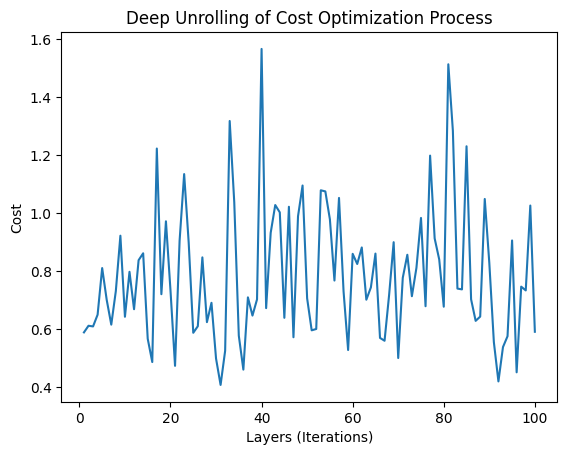

Optimized Parameters: [-700.40025014 -271.7425997   483.00647235  406.97901705  146.24485254
 -125.14560017  426.71865101 -293.97861039   83.01831024 -136.11134398
  117.232567   -864.18163833]
Final Cost: 0.5905812006784747


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_aer import Aer
from qiskit import transpile
from qiskit_machine_learning.datasets import ad_hoc_data

# Set the random seed for reproducibility
np.random.seed(3142)

# Load the dataset
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=2,
    gap=0.3,
    one_hot=False
)

# Define the feature map and variational form
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

# Combine the feature map and variational form into one circuit
AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()

# Function to assign data and variational parameters to the circuit
def circuit_instance(data, variational):
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

# Function to calculate the parity of a bitstring
def parity(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight + 1) % 2

# Function to convert bitstring counts to label probabilities
def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

# Function to classify data points using the given variational parameters
def classification_probability(data, variational):
    circuits = [circuit_instance(d, variational) for d in data]
    backend = Aer.get_backend('qasm_simulator')
    results = []
    for circuit in circuits:
        t_circuit = transpile(circuit, backend)
        result = backend.run(t_circuit).result()
        results.append(result)
    classification = [label_probability(result.get_counts()) for result in results]
    return classification

# Function to calculate cross entropy loss
def cross_entropy_loss(classification, expected):
    p = classification.get(expected)
    return -np.log(p + 1e-10)

# Function to calculate the cost function
def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

# Hyperparameters for deep unrolling
learning_rate = 0.1
max_iters = 100  # Number of layers in deep unrolling

# Initial parameters
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

# Store the initial parameters
params = initial_point.copy()

# Lists to store the cost history
cost_history = []

# Deep unrolling loop
for iteration in range(max_iters):
    # Compute the cost
    current_cost = cost_function(TRAIN_DATA, TRAIN_LABELS, params)

    # Store the cost in the history
    cost_history.append(current_cost)

    # Approximate gradients using finite differences (Simulating gradient step)
    gradients = np.zeros_like(params)
    delta = 1e-5  # Small shift for finite difference approximation

    for i in range(len(params)):
        shift = np.zeros_like(params)
        shift[i] = delta
        cost_plus = cost_function(TRAIN_DATA, TRAIN_LABELS, params + shift)
        cost_minus = cost_function(TRAIN_DATA, TRAIN_LABELS, params - shift)
        gradients[i] = (cost_plus - cost_minus) / (2 * delta)

    # Simulate the update rule (this could be a learned model)
    params -= learning_rate * gradients

    # Print progress
    print(f"Layer {iteration+1}, Cost: {current_cost}")

# Plotting the cost history
plt.plot(range(1, max_iters + 1), cost_history)
plt.xlabel('Layers (Iterations)')
plt.ylabel('Cost')
plt.title('Deep Unrolling of Cost Optimization Process')
plt.show()

# Final optimized parameters and cost
opt_var = params
opt_value = cost_history[-1]

print(f"Optimized Parameters: {opt_var}")
print(f"Final Cost: {opt_value}")


Qiskit VQC

In [ ]:
# This code is part of a Qiskit project.
#
# (C) Copyright IBM 2021, 2023.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.
"""An implementation of variational quantum classifier."""

from __future__ import annotations
from typing import Callable

import numpy as np

from qiskit import QuantumCircuit
from qiskit.primitives import BaseSampler
from qiskit_algorithms.optimizers import Optimizer, OptimizerResult, Minimizer

from qiskit_machine_learning.neural_networks import import SamplerQNN
from ...utils import derive_num_qubits_feature_map_ansatz
from ...utils.loss_functions import Loss

from .neural_network_classifier import NeuralNetworkClassifier


class VQC(NeuralNetworkClassifier):
    r"""A convenient Variational Quantum Classifier implementation.

    The variational quantum classifier (VQC) is a variational algorithm where the measured
    bitstrings are interpreted as the output of a classifier.

    Constructs a quantum circuit and corresponding neural network, then uses it to instantiate a
    neural network classifier.

    Labels can be passed in various formats, they can be plain labels, a one dimensional numpy
    array that contains integer labels like `[0, 1, 2, ...]`, or a numpy array with categorical
    string labels. One hot encoded labels are also supported. Internally, labels are transformed
    to one hot encoding and the classifier is always trained on one hot labels.

    Multi-label classification is not supported. E.g., :math:`[[1, 1, 0], [0, 1, 1], [1, 0, 1]]`.
    """

    def __init__(
        self,
        num_qubits: int | None = None,
        feature_map: QuantumCircuit | None = None,
        ansatz: QuantumCircuit | None = None,
        loss: str | Loss = "cross_entropy",
        optimizer: Optimizer | Minimizer | None = None,
        warm_start: bool = False,
        initial_point: np.ndarray | None = None,
        callback: Callable[[np.ndarray, float], None] | None = None,
        *,
        sampler: BaseSampler | None = None,
    ) -> None:
        """
        Args:
            num_qubits: The number of qubits for the underlying QNN.
                If ``None`` is given, the number of qubits is derived from the
                feature map or ansatz. If neither of those is given, raises an exception.
                The number of qubits in the feature map and ansatz are adjusted to this
                number if required.
            feature_map: The (parametrized) circuit to be used as a feature map for the underlying
                QNN. If ``None`` is given, the :class:`~qiskit.circuit.library.ZZFeatureMap`
                is used if the number of qubits is larger than 1. For a single qubit
                classification problem the :class:`~qiskit.circuit.library.ZFeatureMap`
                is used by default.
            ansatz: The (parametrized) circuit to be used as an ansatz for the underlying QNN.
                If ``None`` is given then the :class:`~qiskit.circuit.library.RealAmplitudes`
                circuit is used.
            loss: A target loss function to be used in training. Default value is ``cross_entropy``.
            optimizer: An instance of an optimizer or a callable to be used in training.
                Refer to :class:`~qiskit_algorithms.optimizers.Minimizer` for more information on
                the callable protocol. When `None` defaults to
                :class:`~qiskit_algorithms.optimizers.SLSQP`.
            warm_start: Use weights from previous fit to start next fit.
            initial_point: Initial point for the optimizer to start from.
            callback: a reference to a user's callback function that has two parameters and
                returns ``None``. The callback can access intermediate data during training.
                On each iteration an optimizer invokes the callback and passes current weights
                as an array and a computed value as a float of the objective function being
                optimized. This allows to track how well optimization / training process is going on.
            sampler: an optional Sampler primitive instance to be used by the underlying
                :class:`~qiskit_machine_learning.neural_networks.SamplerQNN` neural network. If
                ``None`` is passed then an instance of the reference Sampler will be used.
        Raises:
            QiskitMachineLearningError: Needs at least one out of ``num_qubits``, ``feature_map`` or
                ``ansatz`` to be given. Or the number of qubits in the feature map and/or ansatz
                can't be adjusted to ``num_qubits``.
        """

        num_qubits, feature_map, ansatz = derive_num_qubits_feature_map_ansatz(
            num_qubits, feature_map, ansatz
        )

        # construct circuit
        self._feature_map = feature_map
        self._ansatz = ansatz
        self._num_qubits = num_qubits
        self._circuit = QuantumCircuit(self._num_qubits)
        self._circuit.compose(self.feature_map, inplace=True)
        self._circuit.compose(self.ansatz, inplace=True)

        neural_network = SamplerQNN(
            sampler=sampler,
            circuit=self._circuit,
            input_params=self.feature_map.parameters,
            weight_params=self.ansatz.parameters,
            interpret=self._get_interpret(2),
            output_shape=2,
            input_gradients=False,
        )

        super().__init__(
            neural_network=neural_network,
            loss=loss,
            one_hot=True,
            optimizer=optimizer,
            warm_start=warm_start,
            initial_point=initial_point,
            callback=callback,
        )

    @property
    def feature_map(self) -> QuantumCircuit:
        """Returns the used feature map."""
        return self._feature_map

    @property
    def ansatz(self) -> QuantumCircuit:
        """Returns the used ansatz."""
        return self._ansatz

    @property
    def circuit(self) -> QuantumCircuit:
        """Returns the underlying quantum circuit."""
        return self._circuit

    @property
    def num_qubits(self) -> int:
        """Returns the number of qubits used by ansatz and feature map."""
        return self.circuit.num_qubits

    def _fit_internal(self, X: np.ndarray, y: np.ndarray) -> OptimizerResult:
        """
        Fit the model to data matrix X and targets y.

        Args:
            X: The input feature values.
            y: The input target values. Required to be one-hot encoded.

        Returns:
            Trained classifier.
        """
        X, y = self._validate_input(X, y)
        num_classes = self._num_classes

        # instance check required by mypy (alternative to cast)
        if isinstance(self._neural_network, SamplerQNN):
            self._neural_network.set_interpret(self._get_interpret(num_classes), num_classes)

        function = self._create_objective(X, y)
        return self._minimize(function)

    def _get_interpret(self, num_classes: int):
        def parity(x: int, num_classes: int = num_classes) -> int:
            return x % num_classes

        return parity


ImportError: attempted relative import with no known parent package